In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import random
import math
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,BatchNormalization,Dropout


In [2]:
plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

# Loading the dataset: 

In [3]:
def display(images,a):
        m,n = 1, int(len(images)/a)
        for i in range(0,len(images),m*n):
            fig = plt.figure(figsize=(15,8))
            for j in range(m*n):
                fig.add_subplot(m,n,j+1)
                plt.imshow(images[i+j])
                plt.axis('off')
            plt.show()

In [4]:
import glob
data = glob.glob('dataset/Elyas MBarek/*.jpg')
data += glob.glob('dataset/Han Ye-seul/*.jpg')
data += glob.glob('dataset/Mahira Khan/*.jpg')
data += glob.glob('dataset/Ramy Youssef/*.jpg')
data += glob.glob('dataset/Riyad Mahrez/*.jpg')

In [5]:
print(f'This data has {len(data)} images')

This data has 1370 images


# Data Cleaning:

When using web scraping tools to download images, it’s common to encounter images that don’t meet your specific criteria. For our purposes, we only utilize images that clearly display the face and both eyes. This ensures that the images are suitable for facial recognition, analysis, or any other intended use cases requiring a full, unobstructed view of the face. Images that do not meet these standards are excluded to maintain the quality and relevance of our dataset. 

In [6]:
import mediapipe as mp

# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.2)

In [7]:
# Detects if a face exists in the given image using MediaPipe Face Detection.
def detect_face_in_image(image_path):
    # Check if file exists
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return False
    
    # Read the image
    img = cv2.imread(image_path)
    
    # Check if image was loaded correctly
    if img is None:
        print(f"Failed to load image: {image_path}")
        return False
    
    # Convert the image to RGB (MediaPipe uses RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Perform face detection
    results = face_detection.process(img_rgb)
    
    # Check if faces were detected
    if results.detections:
        return True
    else:
        return False


In [8]:
cleaned_data = [path for path in data if detect_face_in_image(path)]
print(f'we remove {len(data) - len(cleaned_data)} image')

Failed to load image: dataset/Elyas MBarek\Image_204.jpg
we remove 112 image


# Preprocessing:

### 1. Resize all the images:

In [9]:
# Resize the image
def resize_image(image_path, width, height, grayscale=False):
    image = cv2.imread(image_path)
    # Resize the image to the given width and height
    resized_image = cv2.resize(image, (width, height))
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    
    # Optionally convert to grayscale
    if grayscale:
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        
    resized_image = resized_image / 255
    return resized_image

In [10]:
Images = []
for img in cleaned_data:
    Images.append(resize_image(img,128,128))
    

### 2. Labeled the images:

In [11]:
# Create a mapping for labels
label_map = {'Mahira Khan': 0, 'Han Ye-seul': 1, 'Riyad Mahrez': 2, 'Elyas MBarek': 3, 'Ramy Youssef': 4}

# Assign labels using a list comprehension
Y = np.array([label_map[x.split('\\')[0].split('/')[-1]] for x in cleaned_data])

# Convert images to numpy array (if not already)
Images = np.array(Images)

# Shuffle the dataset
Images, Y = shuffle(Images, Y, random_state=0)


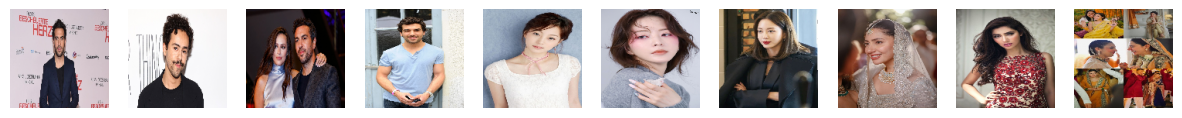

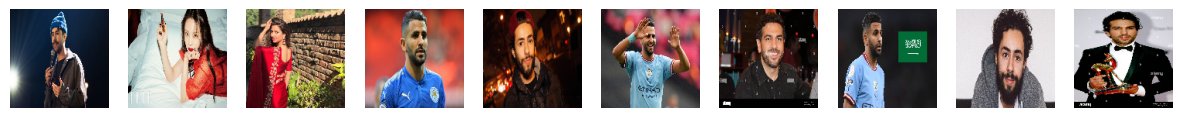

In [12]:
# Display a subset of the images
display(Images[2:22], 2)

# Split the images into train and test:

In [13]:
train,test ,ytrain,ytest =train_test_split(Images, Y, train_size=0.8)

# CNN model:

In [14]:
CNN = Sequential()

CNN.add(Conv2D(32,(3,3),1,activation = 'relu',input_shape=(128,128,3)))
CNN.add(Conv2D(64,(3,3),1,activation = 'relu'))#,padding = 'same',kernel_regularizer = regularizers.l2(0.01)))
CNN.add(MaxPooling2D())
CNN.add(BatchNormalization())

CNN.add(Conv2D(128,(3,3),1,activation = 'relu'))#,padding = 'same',kernel_regularizer = regularizers.l2(0.01)))
CNN.add(MaxPooling2D())
CNN.add(Dropout(0.6))
CNN.add(Conv2D(64,(3,3),1,activation = 'relu'))#,padding = 'same',kernel_regularizer = regularizers.l2(0.01)))
CNN.add(MaxPooling2D())
CNN.add(BatchNormalization())

CNN.add(Flatten())
CNN.add(Dropout(0.2))
CNN.add(Dense(256,activation='relu'))#,kernel_regularizer = regularizers.l2(0.01)))
CNN.add(BatchNormalization())
CNN.add(Dense(5,activation = 'softmax'))

In [15]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.001, nesterov=True)
CNN.compile(optimizer =opt,loss = tf.losses.SparseCategoricalCrossentropy(),metrics = ['accuracy'])

In [16]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0

# Train the model:

In [17]:
hist = CNN.fit(train,ytrain.reshape(-1,1),epochs = 50, validation_split=0.15)

Epoch 1/50
27/27 [==============================] - 34s 1s/step - loss: 1.6562 - accuracy: 0.4070 - val_loss: 1.7105 - val_accuracy: 0.1589
Epoch 2/50
27/27 [==============================] - 29s 1s/step - loss: 1.1535 - accuracy: 0.5649 - val_loss: 2.0968 - val_accuracy: 0.2185
Epoch 3/50
27/27 [==============================] - 26s 970ms/step - loss: 0.8811 - accuracy: 0.6550 - val_loss: 1.7262 - val_accuracy: 0.2384
Epoch 4/50
27/27 [==============================] - 33s 1s/step - loss: 0.7093 - accuracy: 0.7333 - val_loss: 2.4998 - val_accuracy: 0.1589
Epoch 5/50
27/27 [==============================] - 35s 1s/step - loss: 0.5912 - accuracy: 0.7883 - val_loss: 1.9165 - val_accuracy: 0.2649
Epoch 6/50
27/27 [==============================] - 39s 1s/step - loss: 0.4464 - accuracy: 0.8386 - val_loss: 2.6756 - val_accuracy: 0.1589
Epoch 7/50
27/27 [==============================] - 36s 1s/step - loss: 0.3638 - accuracy: 0.8924 - val_loss: 2.8312 - val_accuracy: 0.1921
Epoch 8/50
27/27 

# Plot the results:

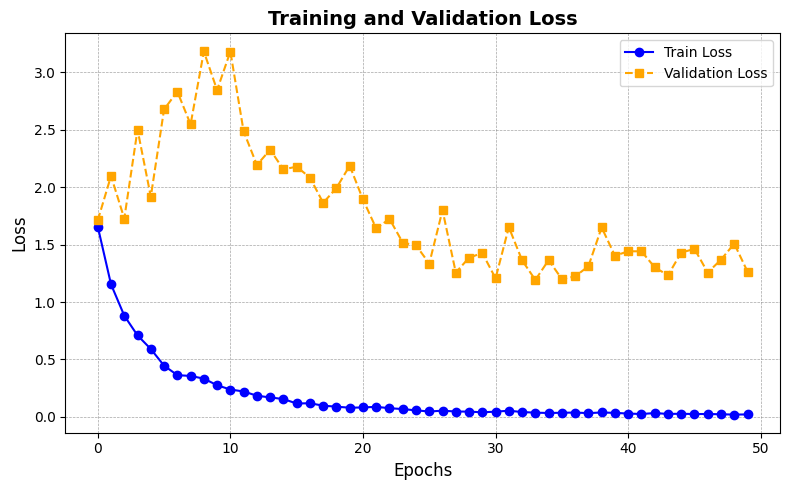

In [22]:
# Plotting training and validation loss with style
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(hist.history['loss'], label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(hist.history['val_loss'], label='Validation Loss', color='orange', linestyle='--', marker='s')

# Adding labels, title, and legend
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout for better spacing

# Show the plot
plt.show()

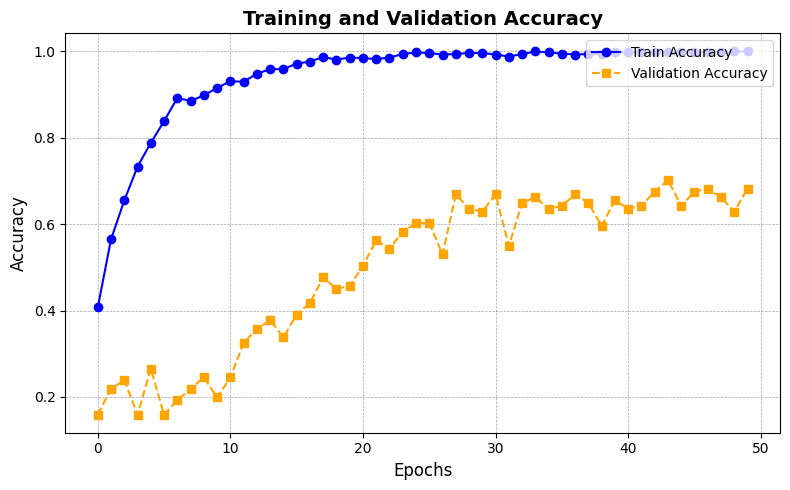

In [23]:
# Plotting training and validation accuracy with style
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(hist.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', marker='s')

# Adding labels, title, and legend
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout for better spacing

# Show the plot
plt.show()

In [24]:
def predictions(y):
    pred = []
    for i in range(0,len(y),5):
        x = y[i:i+100]
        p = np.argmax(x)
        pred.append(p)
    pred = np.array(pred)    
    return pred    

def accuracy(y, pr):
    # Ensure y and pr are numpy arrays for element-wise comparison
    correct_predictions = np.sum(np.equal(y, pr))  # Compare element-wise and sum
    return correct_predictions / y.size

In [25]:
ypred = CNN.predict(test).reshape(-1)
pred = predictions(ypred)
accuracy(ytest,pred)

8/8 [==============================] - 2s 318ms/step


0.047619047619047616